In [ ]:
import numpy as np
import GPy

In [294]:
# Methods for combining differential privacy with Gaussian Processes

import GPy
from sklearn.metrics import mean_squared_error
import numpy as np
import sys
import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

class DPGP(object):
    """(epsilon,delta)-Differentially Private Gaussian Process predictions"""
    
    def __init__(self,model,sens,epsilon,delta):
        """
        Parameters:
            model = Pass a GPy model object
            sens = data sensitivity (how much can one output value vary due to one person
            epsilon = epsilon (DP parameter)
            delta = delta (DP parameter) [probability of providing DP]
            
        """
        self.model = model
        self.sens = sens
        self.epsilon = epsilon
        self.delta = delta
    
    def predict(self,Xtest):
        pass
    
class DPGP_prior(DPGP):
    """
    DP provided by adding a sample from the prior
    """
    
    def __init__(self,model,sens,epsilon,delta):      
        super(DPGP_prior, self).__init__(model,sens,epsilon,delta)
        self.calc_invCov()
        
    def calc_msense(self,A):
        """
        originally returned the infinity norm*, but we've developed an improved value from
        this norm which only cares about values of the same sign (it is assumed that
        those of the opposite sign will work to reduce the sensitivity). We'll call
        this the matrix_sensitivity or msense
        * np.max(np.sum(np.abs(A),1))
        """
        v1 = np.max(np.abs(np.sum(A.copy().clip(min=0),1)))
        v2 = np.max(np.abs(np.sum((-A.copy()).clip(min=0),1)))
        return np.max([v1,v2])
    
    def calc_invCov(self):
        """
        TODO
        """
        sigmasqr = self.model.Gaussian_noise.variance[0]
        K_NN_diags = self.model.kern.Kdiag(self.model.X)
        K_NN = self.model.kern.K(self.model.X)
        invCov = np.linalg.inv(K_NN+sigmasqr*np.eye(K_NN.shape[0]))
        self.invCov = invCov

    def draw_cov_noise_samples(self,test_cov,msense,N=1):        
        """
        Produce differentially private noise for this covariance matrix
        """
        G = np.random.multivariate_normal(np.zeros(len(Xtest)),test_cov,N)
        noise = G*sens*np.sqrt(2*np.log(2/delta))/self.epsilon        
        noise = noise * msense
        return np.array(noise)

    def draw_prediction_samples(self,Xtest,N=1):
        pass #Throw exception (need to inherit from this class to implement this)
    
    def plot(self):
        pass
    
class DPGP_normal_prior(DPGP_prior):
    def draw_noise_samples(self,Xtest,N=1):
        """
        For a given set of test points, find DP noise samples for each
        """
        test_cov = self.model.kern.K(Xtest,Xtest)
        msense = self.calc_msense(self.invCov)
        return self.draw_cov_noise_samples(test_cov,msense,N)
    
    def draw_prediction_samples(self,Xtest,N=1):
        mean, covar = m.predict(Xtest)
        noise = dpgp.draw_noise_samples(Xtest,N).T
        return mean + noise    
    
class DPGP_pseudo_prior(DPGP_prior):
    def draw_noise_samples(self,Xtest,N=1):
        """
        For a given set of test points, find DP noise samples for each
        """
        test_cov = self.model.kern.K(Xtest,Xtest)
        sigmasqr = self.model.Gaussian_noise.variance[0]
        print sigmasqr
        K_NN_diags = self.model.kern.Kdiag(self.model.X)
        K_NN = self.model.kern.K(self.model.X)
        
        K_star = self.model.kern.K(Xtest,self.model.Z.values)
        K_NM = self.model.kern.K(self.model.X,self.model.Z.values)
        K_MM = self.model.kern.K(self.model.Z.values)
        invK_MM = np.linalg.inv(K_MM)
        
        #lambda values are the diagonal of the training input covariances minus 
        #(cov of training+pseudo).(inv cov of pseudo).(transpose of cov of training+pseudo)
        lamb = np.zeros(len(self.model.X))
        for i,t_in in enumerate(self.model.X):
            lamb[i] = K_NN_diags[i] - np.dot(np.dot(K_NM[i,:].T,invK_MM),K_NM[i,:])

        #this finds (\Lambda + \sigma^2 I)^{-1}
        diag = 1.0/(lamb + sigmasqr) #diagonal values

        #rewritten to be considerably less memory intensive (and make it a little quicker)
        Q = K_MM + np.dot(K_NM.T * diag,K_NM)

        #find the mean at each test point
        pseudo_mu = np.dot(     np.dot(np.dot(K_star, np.linalg.inv(Q)),K_NM.T) *  diag  ,y)
        #un-normalise our estimates of the mean (one using the pseudo inputs, and one using normal GP regression)

        #find the covariance for the two methods (pseudo and normal)
        #K_pseudoInv is the matrix in: mu = k_* K_pseudoInv y
        #i.e. it does the job of K^-1 for the inducing inputs case
        K_pseudoInv = np.dot(np.linalg.inv(Q),K_NM.T) * diag

        invlambplussigma = np.diag(1.0/(lamb + sigmasqr)) 
        assert (K_pseudoInv == np.dot(np.dot(np.linalg.inv(Q),K_NM.T),invlambplussigma)).all() #check our optimisation works

        #find the sensitivity for the pseudo (inducing) inputs
        pseudo_msense = self.calc_msense(K_pseudoInv)

        return pseudo_mu, self.draw_cov_noise_samples(test_cov,pseudo_msense,N)

    def draw_prediction_samples(self,Xtest,N=1):
        GPymean, covar = m.predict(Xtest)
        mean, noise = dpgp.draw_noise_samples(Xtest,N)
        np.set_printoptions(precision=2,suppress=True)
        #print GPymean-mean
        return mean + noise.T


In [295]:
X = np.array([[1,2,3,4,5,6]]).T
y = np.array([[2,3,4,5,6,7]]).T
y = y / np.std(y)
m = GPy.models.SparseGPRegression(X,y,num_inducing=2)
m.inference_method = GPy.inference.latent_function_inference.FITC()
m.Gaussian_noise = 0.4
dpgp = DPGP_pseudo_prior(m,5.0,1000.0,0.01)
Xtest = np.arange(0,7,0.1)[:,None]
mu = dpgp.draw_prediction_samples(Xtest,20)

0.4


 /home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning:covariance is not positive-semidefinite.


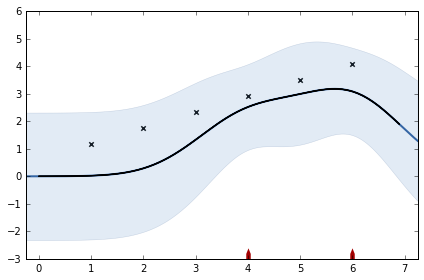

In [296]:
import matplotlib.pyplot as plt
%matplotlib inline
m.plot(legend=False)
plt.plot(Xtest,mu,'-k',alpha=0.3);

In [ ]:
X = np.array([[1,2,3,4,5,6]]).T
y = np.array([[2,3,4,5,6,7]]).T
m = GPy.models.GPRegression(X,y)
m.Gaussian_noise = 5.0
dpgp = DPGP_normal_prior(m,5.0,1.0,0.01)
Xtest = np.arange(0,7,0.1)[:,None]
mu = dpgp.draw_prediction_samples(Xtest,20)